In [2]:
import qiskit as q
import numpy as np

Input any vector of positive integer values of any lenght.

The values in the vector will be converted into binary. The lenght of the highest value in the vector is saved as 'm'. This will determine what vectors will be traced in following steps. 

In [27]:
#Define the input vector in the next variable
vector = [1,5,6,10]

#Obtain the input vector in binary values
binary= [bin(int(i))[2:] for i in vector]

#Check the highest value in the vector. This is 'm'.
f=0
num_max=0
for i in binary:
    if int(i)>= int(f):
        num_max=i
    f=num_max
    
m=len(num_max)
l=len(binary)
n=int(np.ceil(np.log2(l)))

print('Your vector of numbers in binary is:', binary)
print()
print('Its lenght is l='+str(l), 'and the minimum number of bits needed to represent any index on your list is n='+str(n))

Your vector of numbers in binary is: ['1', '101', '110', '1010']

Its lenght is l=4 and the minimum number of bits needed to represent any index on your list is n=2


The following cell builds the list 'good_state' and formats it for ease of use later in the solution. This list, as the name suggests, contains states deemed 'good' by our condition that they should not have two equal adjacent bits.

In [28]:
#Use itertools' product function to obtain all the possible bitstrings of lenght 'm' 
#as parts in a 2D matrix

from itertools import product

good_state=[i for i in product('01',repeat=m)]


#These block of loops clears up the unwanted binary values (those that have consecutive 1's or 0's)
for ii in range(m-1):
    i=0
    while i< len(good_state):
        if good_state[i][ii]==good_state[i][ii+1]:
            good_state.pop(i)
        else:
            i+=1

#Combine the parts left into bitstrings
good_state=[''.join(i) for i in good_state]

#This makes sure there's no 0's in front of the states
good_state=[str(int(i)) for i in good_state]

The following section executes Grover's algorithm to find the correct states in the input list. It prints the index of the correct state, and what the state is.

In [29]:
from qiskit.algorithms import AmplificationProblem
from qiskit.quantum_info import Statevector
from qiskit.algorithms import Grover
save_index=[]

for state in good_state:

    oracle = Statevector.from_label(state)
    problem = AmplificationProblem(oracle, is_good_state=binary)

    aer_simulator = q.Aer.get_backend('aer_simulator')
    grover = Grover(quantum_instance=aer_simulator)
    result = grover.amplify(problem)
    print('Success!' if result.oracle_evaluation else 'Failure!')
    try:
        index=bin(binary.index(state))[2:]



        if result.oracle_evaluation:
            save_index.append(list('{:{size}}'.format(int(index,2),size='0'+str(n)+'b')))

        print('Index: {:{size}}'.format(int(index,2), size='0'+str(n)+'b'))
        print('State: {:{size}}'.format(int(state,2), size='0'+str(m)+'b'))
    except ValueError:
        print('State {:{size}} is not on the list'.format(int(state,2), size='0'+str(m)+'b'))
    print()

Success!
Index: 01
State: 0101

Success!
Index: 11
State: 1010



This next cell will transform the binary value index into vectors. For example, lets use the index '01' 

$$
    01\rightarrow\begin{bmatrix}1\\0\end{bmatrix}\begin{bmatrix}0\\1\end{bmatrix}\rightarrow|01\rangle
$$

In [30]:
print(save_index)
for j in range(len(save_index)):
    for i in range(len(save_index[j])):
        if int(save_index[j][i])==0:
            save_index[j][i]=[1,0]
        else:
            save_index[j][i]=[0,1]
print(save_index)

[['0', '1'], ['1', '1']]
[[[1, 0], [0, 1]], [[0, 1], [0, 1]]]


The function built in the next cell builds a statevector out of the index vectors so a quantum circuit can be initialized with it. For this, the tensor product of the index vectors is evaluated, and the result is then reshaped and normalized.

In [31]:
def indices_to_sv(save_index):
    try:
        sv1=np.tensordot(save_index[0][0],save_index[0][1],axes=0)
        sv1=np.concatenate([sv1[0],sv1[1]])
        for i in range(len(save_index[0])-2):
            sv1=np.tensordot(sv1,save_index[0][i+2],axes=0)
            sv1=np.reshape(sv1, -1)

        sv2=np.tensordot(save_index[1][0],save_index[1][1],axes=0)
        sv2=np.concatenate([sv2[0],sv2[1]])
        for j in range(len(save_index[0])-2):
            sv2=np.tensordot(sv2,save_index[1][j+2],axes=0)
            sv2=np.reshape(sv2, -1)

        sv=sv1+sv2
        norm_sv = sv/np.linalg.norm(sv)
        return norm_sv
    
    except IndexError:
        sv1=np.tensordot(save_index[0][0],save_index[0][1],axes=0)
        sv1=np.concatenate([sv1[0],sv1[1]])
        for i in range(len(save_index[0])-2):
            sv1=np.tensordot(sv1,save_index[0][i+2],axes=0)
            sv1=np.reshape(sv1, -1)
        return sv1

In [46]:
norm_sv=indices_to_sv(save_index)
print('The statevector that describes the indices of the good numbers in your original list is \n',norm_sv)

The statevector that describes the indices of the good numbers in your original list is 
 [0.         0.70710678 0.         0.70710678]


Finally, the results are used to initialize a quantum circuit that can then be simulated in the 'statevector_simulator' backend, and the results are visualized in a histogram.

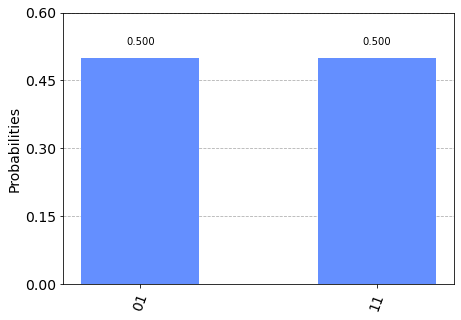

[0.        +0.j 0.70710678+0.j 0.        +0.j 0.70710678+0.j]


In [47]:
from qiskit import QuantumCircuit

qc=QuantumCircuit(n)
qc.initialize(norm_sv)

simulator = q.Aer.get_backend('statevector_simulator')
result = q.execute(qc, simulator).result()
counts=result.get_counts()
plot=q.visualization.plot_histogram(counts)
display(plot)
statevector = result.get_statevector()
print(statevector)